# GAN pix2pix

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## Dataset
O dataset utilizado foi o "Facades"que consiste de imagens de fachadas de edifícios e suas correspondentes anotações de segmentação, que descrevem a estrutura da fachada, incluindo informações sobre diferentes partes da fachada, como janelas, portas e outras características arquitetônicas.

In [2]:
dataset_name = "facades"

# URL para o download do dataset
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

# Baixa o arquivo .tar.gz do dataset e o extrai
path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

## Visualização de uma Imagem de Exemplo
Nesta etapa, carregamos uma imagem do dataset para visualizar como ela é formatada. Cada imagem contém uma representação real da fachada e sua correspondente rotulação arquitetônica.

In [3]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


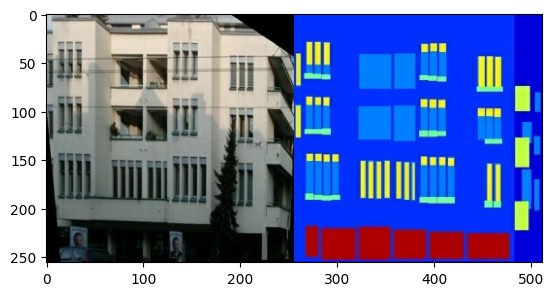

In [4]:
plt.figure()
plt.imshow(sample_image)

## Pré-processamento de imagens
a função load será responsável por carregar e pré-processar as imagens do dataset. A função irá separar a imagem de entrada (input_image) da imagem real (real_image) a partir de uma imagem combinada, onde ambas as partes estão lado a lado.

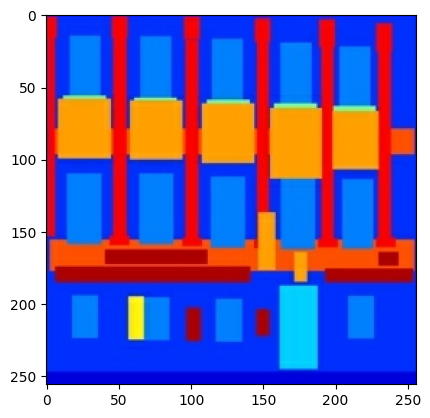

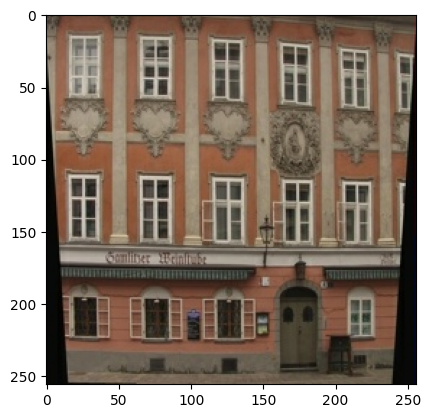

In [5]:
def load(image_file):
  # Decodifica a imagem
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Separa a imagem em partes
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Normaliza as imagens
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

# Carrega e processa as imagem 27
inp, re = load(str(PATH / 'train/27.jpg'))
# Converte as imagens para inteiros para exibição no matplotlib
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [6]:
# O conjunto de treinamento facades consiste em 400 imagens
BUFFER_SIZE = 400
BATCH_SIZE = 1
# Cada imagem tem o tamanho 256x256
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
# Redimensiona a imagem de entrada e a imagem real para a altura e largura especificadas
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
# Empilha as duas imagens juntas e realiza um recorte aleatório
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  # Separa as imagens recortadas
  return cropped_image[0], cropped_image[1]

In [9]:
# Normaliza as imagens para o intervalo [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # Redimensionando para 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Recorte aleatório para 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Espelhamento aleatório horizontal
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

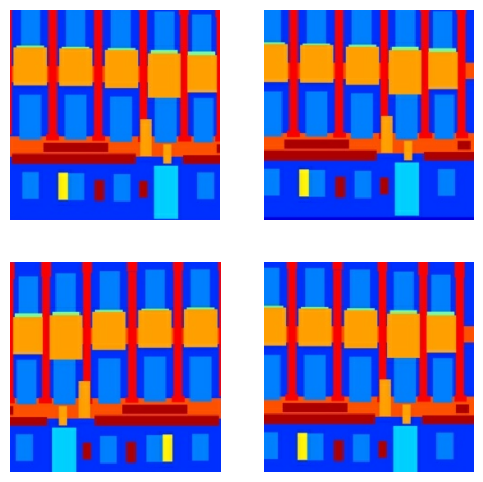

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [12]:
def load_image_train(image_file):
  # Carrega a imagem de entrada e a imagem real
  input_image, real_image = load(image_file)

  # Aplica jittering aleatório durante o treinamento
  input_image, real_image = random_jitter(input_image, real_image)

  # Normaliza as imagens para o intervalo [-1, 1]
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
def load_image_test(image_file):
  # Carrega a imagem de entrada e a imagem real
  input_image, real_image = load(image_file)

  # Redimensiona as imagens para 256x256
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)

  # Normaliza as imagens para o intervalo [-1, 1]
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:
# Cria um dataset para as imagens de treinamento
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
# Aplica a função de pré-processamento para treinamento
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
# Embaralha o dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# Agrupa as imagens em batches
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
# cria um dataset para as imagens de teste
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
# Aplica a função de pré-processamento para teste
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Gerador
O gerador consiste de um codificador (downsampler) e um decodificador (upsampler). Cada bloco no codificador é: Convolution -> Batch normalization -> Leaky ReLU. Cada bloco no decodificador é: Convolução transposta -> Normalização em lote -> Dropout (aplicado aos 3 primeiros blocos) -> ReLU

### Codificador

In [16]:
# Número de canais de saída para as imagens
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  # Inicializador para os pesos das camadas convolucionais
  initializer = tf.random_normal_initializer(0., 0.02)
  # Criação de um modelo sequencial para empilhar as camadas
  result = tf.keras.Sequential()
  # Adiciona uma camada de convolução
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  # Adiciona uma camada de normalização em lote, se necessário
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  # Adiciona LeakyReLU para a função de ativação
  result.add(tf.keras.layers.LeakyReLU())

  return result

### Decodificador

In [17]:
def upsample(filters, size, apply_dropout=False):
  # Inicializador para os pesos das camadas convolucionais
  initializer = tf.random_normal_initializer(0., 0.02)
  # Criação de um modelo sequencial para empilhar as camadas
  result = tf.keras.Sequential()
  # Adiciona uma camada de transposição convolucional para upsampling
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  # Adiciona BatchNormalization
  result.add(tf.keras.layers.BatchNormalization())
  # Adiciona Dropout se solicitado
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))
  # Adiciona ReLU para a função de ativação
  result.add(tf.keras.layers.ReLU())

  return result

### Gerador

In [18]:
def Generator():
  # Camada de entrada com tamanho 256x256x3
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # Camadas de downsampling (encoder)
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  # Camadas de upsampling (decoder)
  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  # Inicializador para a última camada convolucional
  initializer = tf.random_normal_initializer(0., 0.02)
  # Última camada de transposição convolucional para gerar a imagem final
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Passa a imagem através das camadas de downsampling (encoder)
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Passa a imagem através das camadas de upsampling (decoder) e adiciona skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  # Aplica a última camada de transposição convolucional para obter a imagem gerada
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Agora testamos o gerador

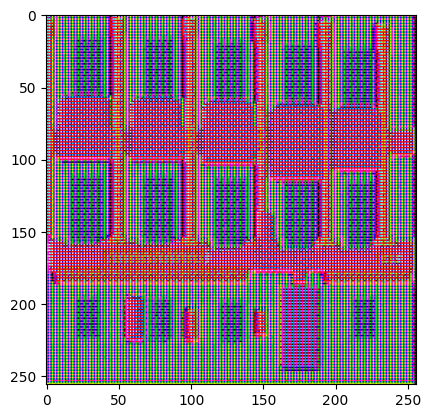

In [19]:
generator = Generator()
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Função de Perda do Gerador
A função de perda do gerador é composta por duas partes principais: a perda GAN e a perda L1 (erro absoluto médio).

In [20]:
# Fator de regularização para a perda L1
LAMBDA = 100
# Função de perda binária cruzada
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(disc_generated_output, gen_output, target):
  # Perda GAN
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Perda L1 (erro absoluto médio)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # Perda total do gerador
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Discriminador
O discriminador é responsável por distinguir entre imagens reais e imagens geradas pelo gerador. Ele toma uma imagem real e uma imagem gerada como entrada e tenta classificar se a imagem combinada é real ou falsa.

In [22]:
def Discriminator():
 # Inicializador para os pesos das camadas convolucionais
  initializer = tf.random_normal_initializer(0., 0.02)

  # Camada de entrada para a imagem de entrada e a imagem alvo
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  # Concatena as imagens de entrada e alvo
  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  # Camadas de downsampling
  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  # Padding zero para manter o tamanho da imagem após convolução
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)

  # Convolução para extrair características mais profundas
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  # Normalização em lote para estabilizar o treinamento
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  # Função de ativação LeakyReLU
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  # Padding zero adicional
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  # Última camada de convolução para classificação
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [23]:
discriminator = Discriminator()

### Função de Perda do Discriminador
A função de perda do discriminador é responsável por avaliar a capacidade do discriminador de distinguir entre imagens reais e imagens geradas pelo gerador. A perda do discriminador é composta por duas partes: a perda para imagens reais e a perda para imagens geradas.

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output):
  # Perda para imagens reais
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Perda para imagens geradas
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  # Perda total do discriminador
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Otimizadores
Os otimizadores são responsáveis por atualizar os pesos dos modelos durante o treinamento para minimizar as funções de perda.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Função para gerar e exibir imagens

In [26]:
def generate_images(model, test_input, tar):
  # Gera a imagem usando o modelo
  prediction = model(test_input, training=True)
  # Cria uma figura para exibir as imagens
  plt.figure(figsize=(15, 15))

  # Lista de imagens a serem exibidas
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  # Exibe as imagens
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

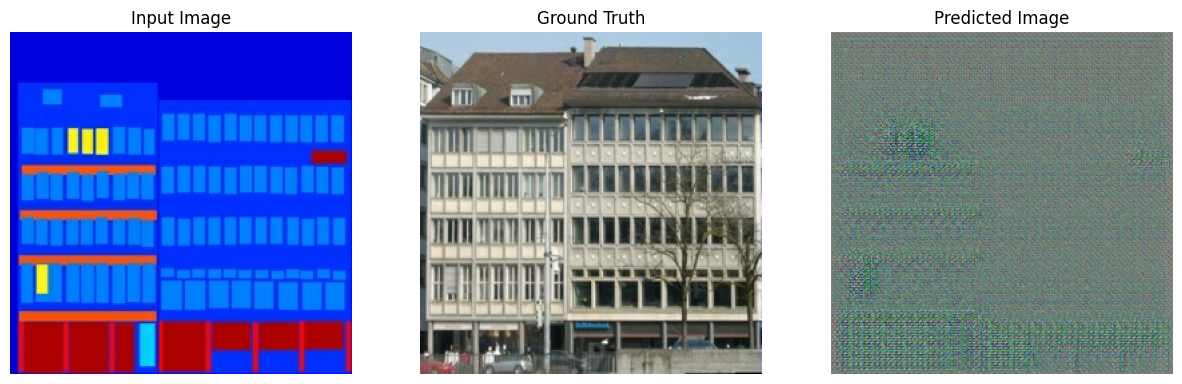

In [27]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Treinamento


In [28]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Gera a imagem a partir da imagem de entrada
    gen_output = generator(input_image, training=True)

    # Calcula a saída do discriminador para imagens reais e geradas
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    # Calcula a perda do gerador e a perda do discriminador
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Calcula os gradientes para o gerador e o discriminador
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
  # Aplica os gradientes para atualizar os pesos
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [29]:
def fit(train_ds, test_ds, steps):
  # Obtém uma imagem de exemplo do conjunto de dados de teste
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  # Loop de treinamento
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    # A cada 5000 passos, exibe o progresso e o tempo decorrido
    if (step) % 5000 == 0:
      if step != 0:
        print(f'Time taken for 5000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()
      # Gera e exibe imagens de exemplo
      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    # Executa um passo de treinamento
    train_step(input_image, target, step)

    # Exibe um ponto a cada 50 passos para indicar o progresso
    if (step+1) % 50 == 0:
      print('.', end='', flush=True)

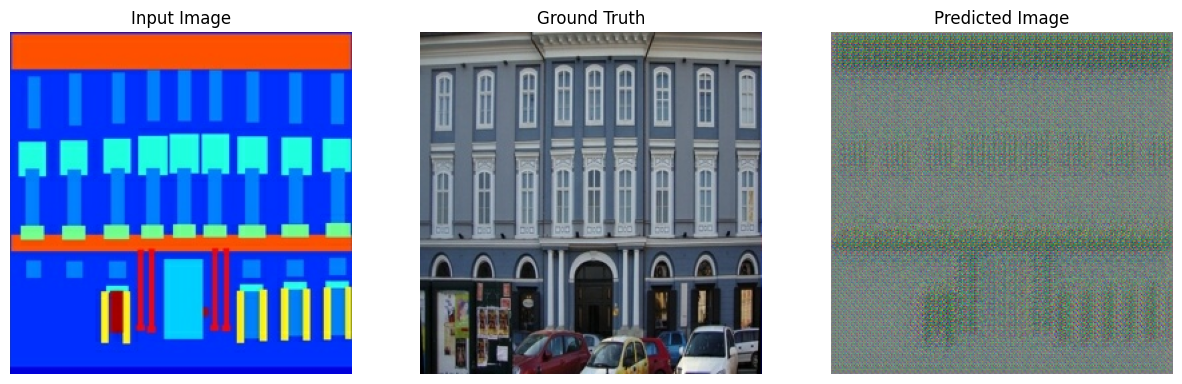

Step: 0k
...................................................................................................Time taken for 5000 steps: 574.85 sec



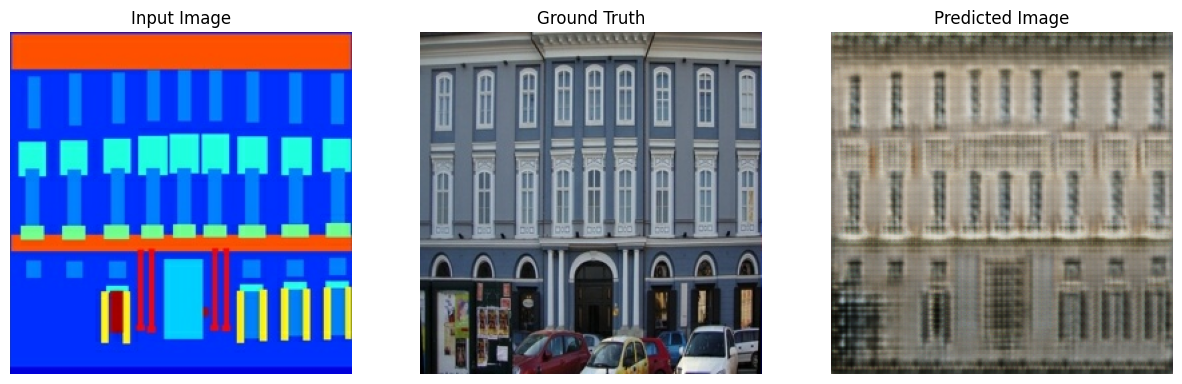

Step: 5k
...................................................................................................Time taken for 5000 steps: 567.89 sec



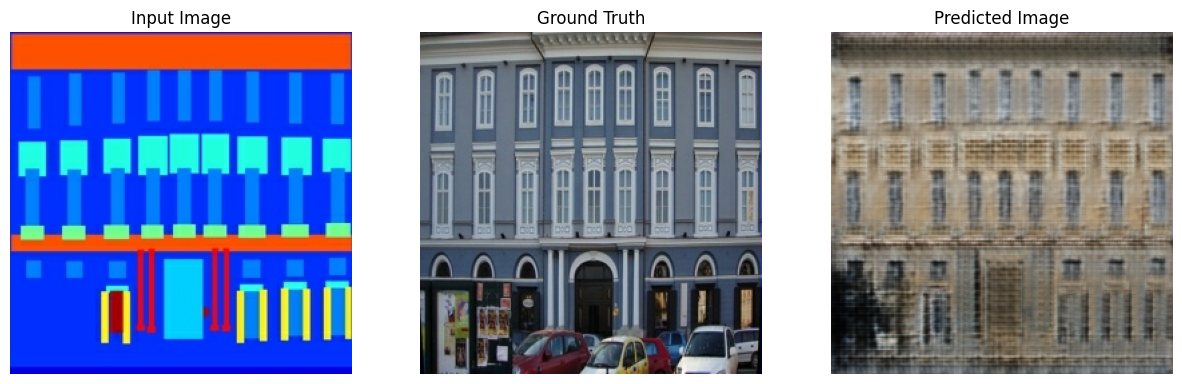

Step: 10k
....................................................................................................Time taken for 5000 steps: 568.01 sec



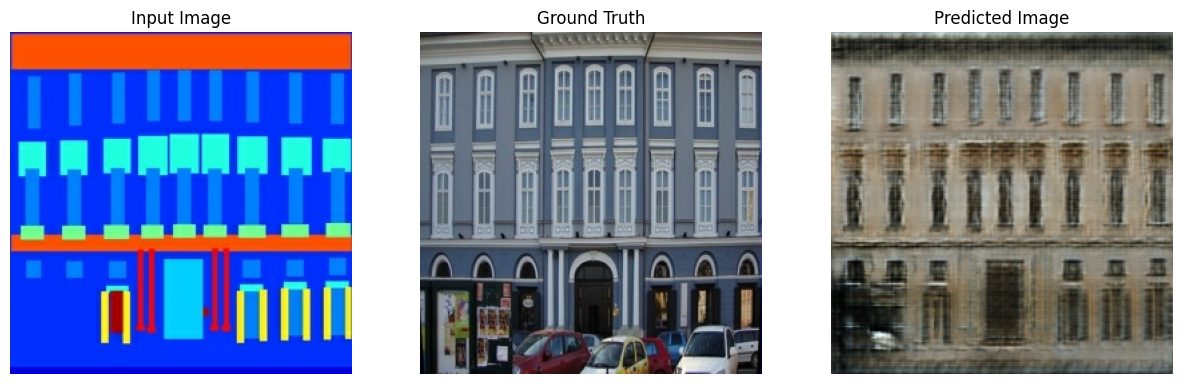

Step: 15k
...................................................................................................Time taken for 5000 steps: 567.23 sec



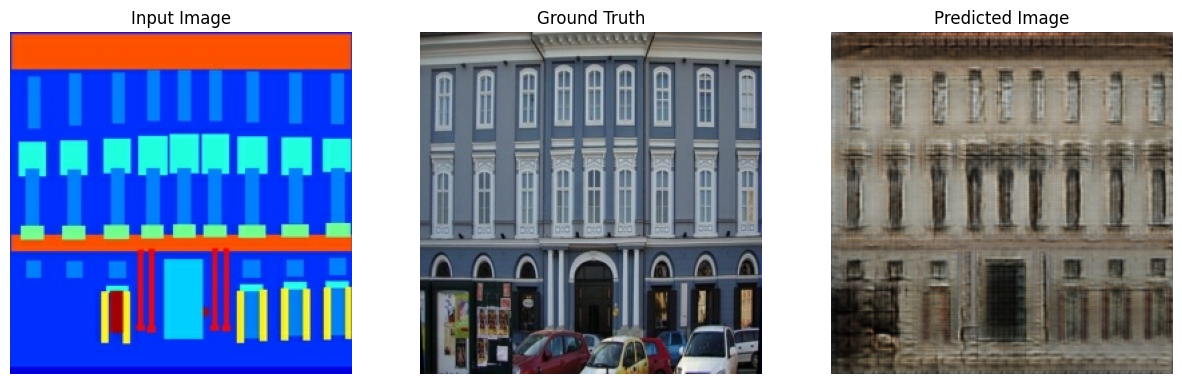

Step: 20k
....................................................................................................Time taken for 5000 steps: 566.60 sec



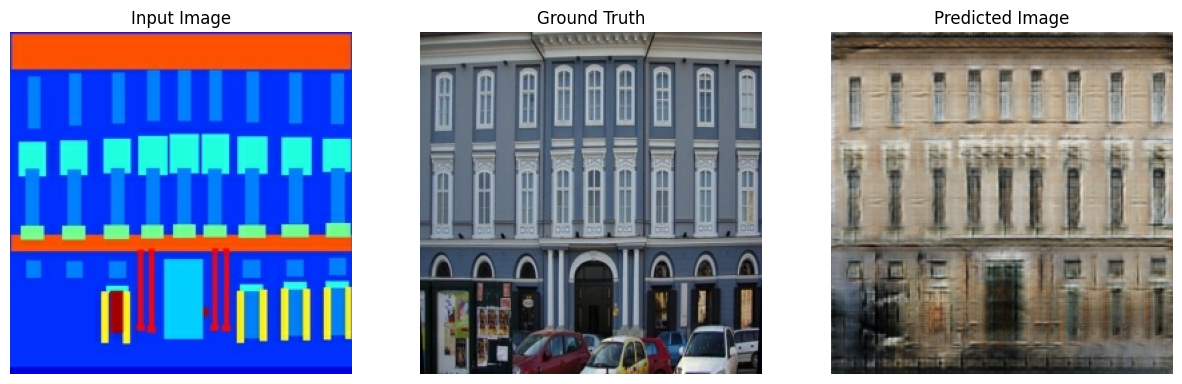

Step: 25k
...................................................................................................Time taken for 5000 steps: 567.00 sec



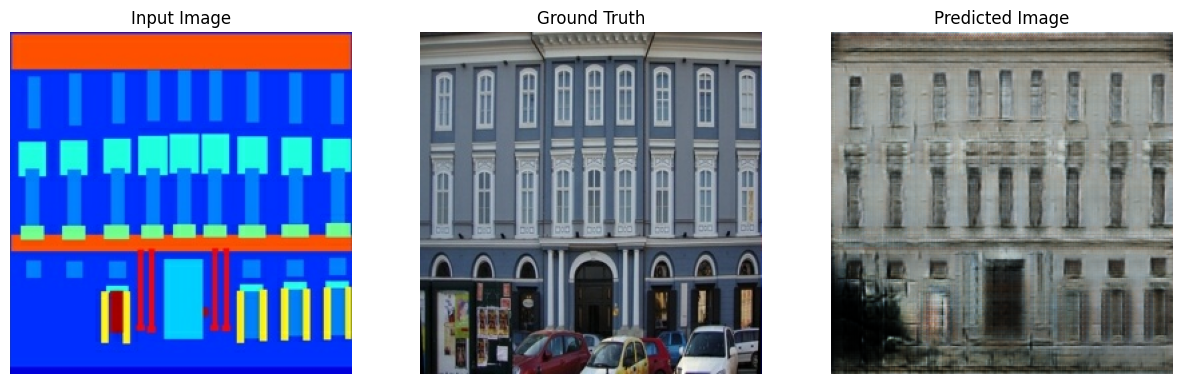

Step: 30k
...................................................................................................Time taken for 5000 steps: 567.58 sec



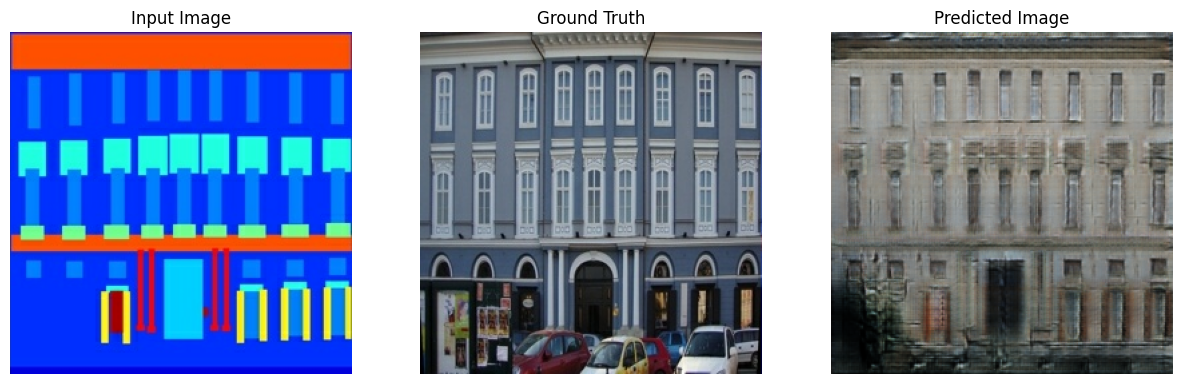

Step: 35k
....................................................................................................

In [32]:
fit(train_dataset, test_dataset, steps=40000)

## Geração de imagens de exemplos
Vamos agora ver mais exemplos de imagens geradas pelo modelo

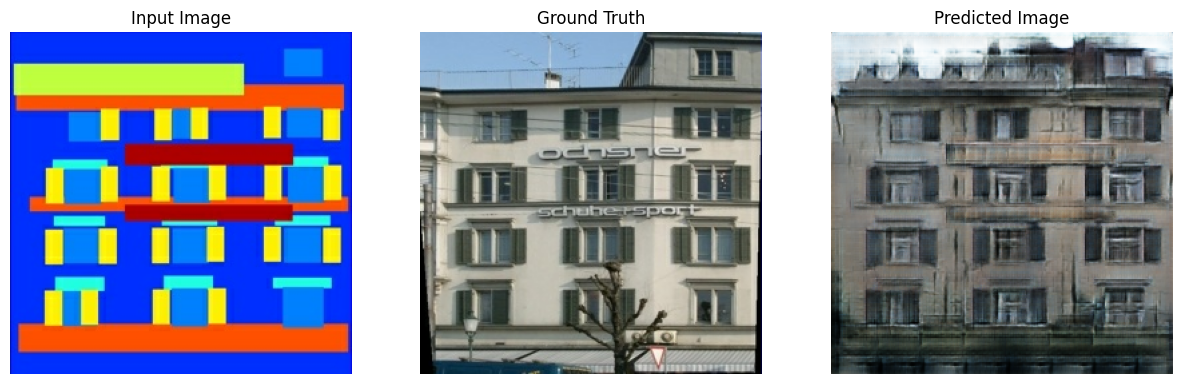

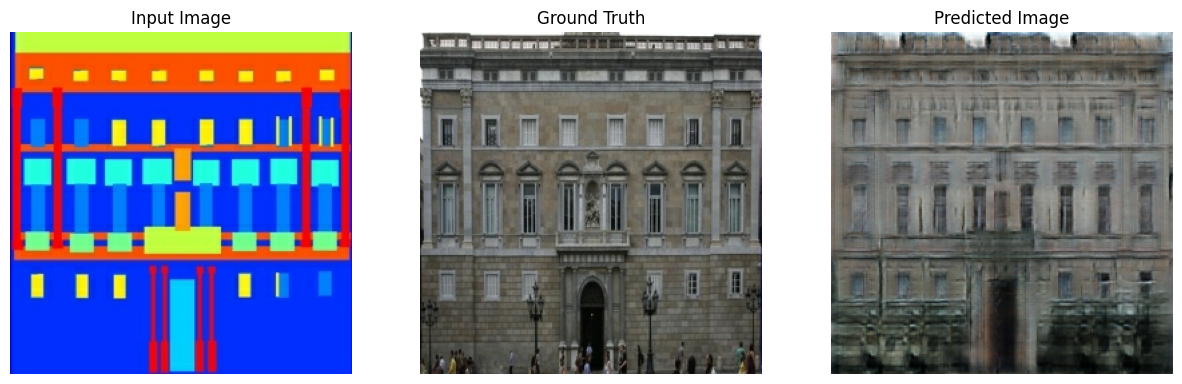

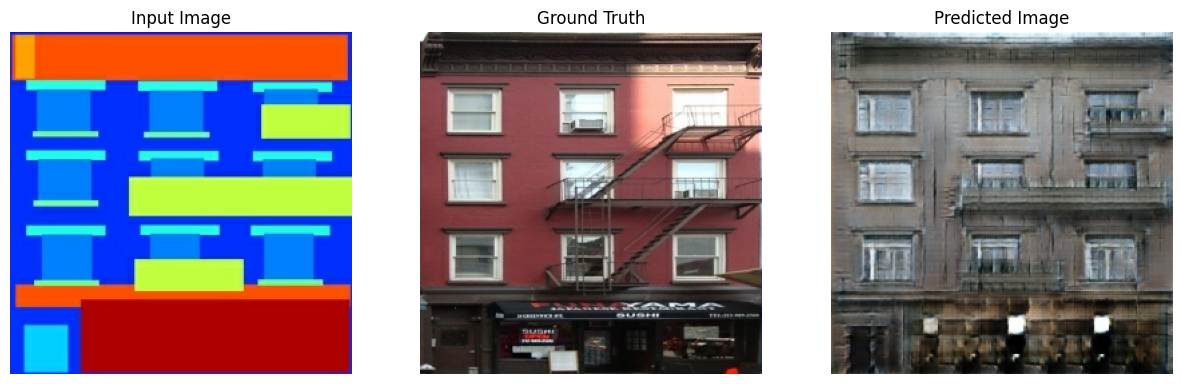

In [33]:
for _ in range(3):
  example_input, example_target = next(iter(test_dataset.take(1)))
  generate_images(generator, example_input, example_target)